In [1]:
from openai import OpenAI
import random

client = OpenAI(api_key='')


In [2]:
import os
import json

email_dir = "data/Cater Mails/email threads"
gt_dir = "data/Cater Mails/ground truth"

os.makedirs(email_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)

num_threads = 10

for i in range(1, 1001):
    PROMPT_TEMPLATE = """
You are simulating a realistic business email exchange between:
- Food Supplier (Caterer)
- Event Organizer

Generate an email thread with exactly four messages. The final message must always be written by the Event Organizer.

CRITICAL WRITING RULES:
- Do NOT use placeholders, brackets, or template-style text.
- Always generate realistic personal names and company names.
- Do NOT use bullet points, numbered lists, bold text, headings, or markdown.
- Write only in natural business email prose, using full sentences and paragraphs.
- Do NOT explicitly label or name data fields.
- All details must be embedded naturally in the conversation.

CONTENT REQUIREMENTS:
Across the full email thread, the following information must be mentioned clearly
but implicitly, in natural language, so it can be inferred later:

- The type of event being catered.
- The pricing structure (per person, fixed price, or range).
- A concrete final price value if a deal is accepted.
- Minimum and maximum number of guests, if applicable.
- Whether VAT is included or added on top.
- Whether the food is kosher, and if so, under what supervision.
- Whether a bar or beverages are included or explicitly excluded.
- The general menu type (meat, dairy, mixed, pareve, or unclear).
- Available dietary accommodations.
- The event date.
- The cancellation terms.
- Representative menu items or dishes.
- Any additional relevant notes (timing, setup, staffing, equipment, etc.).

It is acceptable for some information to be omitted or left unclear if the context
naturally supports it.

Thread length rules:
- The email thread must have four messages.
- A short negotiation occurs in emails 2 and 3.
- The final email clearly accepts or cancels the agreement.

At the end of the email thread, output a JSON object containing all the features used in the thread.
Use the following keys exactly: 
event_type, price_type, final_price_value, min_guests, max_guests,
includes_vat, is_kosher, kosher_supervision, includes_bar,
menu_type, dietary_options, event_date, cancellation_policy,
menu_highlights, extra_notes
Use null for missing values. Do not add explanations or extra text. Separate the JSON from the email thread with a clear delimiter: "--- FEATURES JSON ---".

Output format:

Email 1 – Food Supplier:
<email>

Email 2 – Event Organizer:
<email>

Email 3 – Food Supplier:
<email>

Email 4 – Event Organizer:
<email>

--- FEATURES JSON ---
<JSON with all feature values>
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": PROMPT_TEMPLATE}],
        temperature=0.7,
        max_tokens=1000
    )
    output_text = response.choices[0].message.content
    try:
        email_thread_text, features_json_text = output_text.split('--- FEATURES JSON ---')
        email_thread_text = email_thread_text.strip()
        features_json_text = features_json_text.strip()
        ground_truth_features = json.loads(features_json_text)
    except Exception as e:
        print(f"Error parsing thread {i}:", e)
        email_thread_text = output_text
        ground_truth_features = {"error": "Invalid JSON", "raw_output": output_text}
    
    email_file = os.path.join(email_dir, f"email_thread_{i:03d}.txt")
    json_file = os.path.join(gt_dir, f"ground_truth_{i:03d}.json")

    with open(email_file, "w", encoding="utf-8") as f:
        f.write(email_thread_text)
    
    with open(json_file, "w", encoding="utf-8") as f:
        json.dump(ground_truth_features, f, indent=2)


In [91]:
print("=== EMAIL THREAD ===")
print(email_thread_text)
print("\n=== FEATURES JSON ===")
print(json.dumps(ground_truth_features, indent=2))

=== EMAIL THREAD ===
Email 1 – Food Supplier:  
Subject: Catering Proposal for Your Upcoming Event  

Dear Sarah,  

Thank you for reaching out to us regarding your upcoming corporate gala on November 15th. We would be delighted to provide catering services for this event. Our menu features a variety of options, including a selection of meat and dairy dishes, all prepared under strict kosher supervision by the Orthodox Union.  

For your event, we typically charge $45 per person, which includes a full buffet setup, staff for serving, and all necessary equipment. This pricing is inclusive of VAT. We can accommodate between 50 to 150 guests, and we are happy to provide dietary options for any guests with specific needs.  

Please let me know if you would like to discuss the menu further or if you have any specific requests.  

Best regards,  
David Cohen  
Culinary Delights Catering  

Email 2 – Event Organizer:  
Subject: Re: Catering Proposal for Your Upcoming Event  

Hi David,  

Tha

In [10]:
import json

pred_dir = "data/Cater Mails/extracted features zero-shot"

os.makedirs(pred_dir, exist_ok=True)

def extract_features_gpt4(email_thread: str):
    prompt = f"""
You are an expert information extraction system specialized in business email threads.  
Your task is to extract structured features **exactly in the JSON format below** from this email thread.  

Instructions:
- Output only valid JSON. Do not add explanations, comments, or extra text.  
- Use null for missing values.  
- Always return arrays for list fields, even if there is only one item.  
- Booleans must be true or false.  
- Strings must be concise and plain text, no extra punctuation or symbols.  
- For categorical fields, only use the specified exact values. Do not write synonyms.  
- Ensure date format is YYYY-MM-DD.  
- Only include items explicitly mentioned in the email thread.  

Required JSON format:
{{
  "event_type": "string or null",
  "price_type": "per_person | fixed | range | unknown",
  "final_price_value": number or null,
  "min_guests": number or null,
  "max_guests": number or null,
  "includes_vat": true | false | null,
  "is_kosher": true | false | null,
  "kosher_supervision": "string or null",
  "includes_bar": true | false | null,
  "menu_type": "meat | dairy | mixed | pareve | unknown",
  "dietary_options": ["array of strings"],
  "event_date": "YYYY-MM-DD or null",
  "cancellation_policy": "string or null",
  "menu_highlights": ["array of strings"],
  "extra_notes": "string or null"
}}

Extract these fields directly from the email thread below.  
For lists, include only the items actually mentioned. For categorical fields, only use the exact allowed values.  

Email thread:
{email_thread}
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=500
    )
    text = response.choices[0].message.content
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON", "raw_output": text}

for i in range(1, 1001):
    email_file = os.path.join(email_dir, f"email_thread_{i:03d}.txt")
    json_file = os.path.join(pred_dir, f"extracted_features_{i:03d}.json")


    with open(email_file, "r", encoding="utf-8") as f:
        thread_text = f.read()

    predicted_features = extract_features_gpt4(thread_text)

    with open(json_file, "w", encoding="utf-8") as f:
        json.dump(predicted_features, f, indent=2)


In [93]:
print(json.dumps(predicted_features, indent=2))


{
  "event_type": "catering",
  "price_type": "fixed",
  "final_price_value": 4400,
  "min_guests": 50,
  "max_guests": 100,
  "includes_vat": true,
  "is_kosher": true,
  "kosher_supervision": "Orthodox Union",
  "includes_bar": true,
  "menu_type": "mixed",
  "dietary_options": [
    "vegetarian",
    "dietary restrictions"
  ],
  "event_date": "2023-06-15",
  "cancellation_policy": "10 days prior to the event",
  "menu_highlights": [
    "herb-roasted chicken",
    "grilled vegetable platters",
    "variety of salads",
    "stuffed bell peppers",
    "pasta dishes"
  ],
  "extra_notes": "point person from catering team present during the event"
}


In [5]:
FEW_SHOT_EXAMPLE = """
Example:

Email thread:
Email 1 – Food Supplier:
Thank you for contacting us regarding catering for your upcoming gala on May 15th. We offer a mixed menu including meat and dairy options. The price is $75 per person including VAT. Minimum 100 guests, maximum 300. Kosher under Orthodox Union supervision. Bar service not included.

Email 2 – Event Organizer:
Could you reduce the price to $65 per person? We expect around 150 guests. Does the price include a bar?

Email 3 – Food Supplier:
I can offer $70 per person for 150 guests including VAT. Bar service is an additional $15 per person. We support vegetarian and gluten-free diets.

Email 4 – Event Organizer:
We accept $70 per person for 150 guests including VAT and would like to include the bar service.

Extracted JSON:
{
  "event_type": "gala",
  "price_type": "per_person",
  "final_price_value": 70,
  "min_guests": 100,
  "max_guests": 300,
  "includes_vat": true,
  "is_kosher": true,
  "kosher_supervision": "Orthodox Union",
  "includes_bar": true,
  "menu_type": "mixed",
  "dietary_options": ["gluten-free", "vegetarian"],
  "event_date": "2023-05-15",
  "cancellation_policy": null,
  "menu_highlights": [],
  "extra_notes": null
}
"""

def extract_features_gpt4_fewshot(email_thread: str):
    prompt = f"""
You are an expert information extraction system specialized in business email threads.

Below is an example of a correctly extracted email thread and its JSON output.
Follow the same logic and formatting.

{FEW_SHOT_EXAMPLE}

Now extract features from the following email thread.

Instructions:
- Output only valid JSON.
- Use null for missing values.
- Always return arrays for list fields.
- Use only allowed categorical values.
- Date format: YYYY-MM-DD.

Required JSON format:
{{
  "event_type": "string or null",
  "price_type": "per_person | fixed | range | unknown",
  "final_price_value": number or null,
  "min_guests": number or null,
  "max_guests": number or null,
  "includes_vat": true | false | null,
  "is_kosher": true | false | null,
  "kosher_supervision": "string or null",
  "includes_bar": true | false | null,
  "menu_type": "meat | dairy | mixed | pareve | unknown",
  "dietary_options": ["array of strings"],
  "event_date": "YYYY-MM-DD or null",
  "cancellation_policy": "string or null",
  "menu_highlights": ["array of strings"],
  "extra_notes": "string or null"
}}

Email thread:
{email_thread}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=500
    )

    text = response.choices[0].message.content
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON", "raw_output": text}



In [7]:
pred_dir_fewshot = "data/Cater Mails/extracted features few-shot"
os.makedirs(pred_dir_fewshot, exist_ok=True)

for i in range(1, 1001):
    email_file = os.path.join(email_dir, f"email_thread_{i:03d}.txt")
    json_file = os.path.join(pred_dir_fewshot, f"extracted_features_{i:03d}.json")

    with open(email_file, "r", encoding="utf-8") as f:
        thread_text = f.read()

    predicted_features = extract_features_gpt4_fewshot(thread_text)

    with open(json_file, "w", encoding="utf-8") as f:
        json.dump(predicted_features, f, indent=2)


In [10]:
from collections import defaultdict

BASE_DIR = "data/Cater Mails"
PRED_DIR = os.path.join(BASE_DIR, "extracted features zero-shot")
GOLD_DIR = os.path.join(BASE_DIR, "ground truth")

BOOLEAN_FIELDS = {"includes_vat", "is_kosher", "includes_bar"}
LIST_FIELDS = {"dietary_options", "menu_highlights"}

def normalize(value):
    if value is None:
        return None
    if isinstance(value, str):
        return value.strip().lower()
    if isinstance(value, list):
        return [str(x).strip().lower() for x in value]
    return value

def convert_to_list(value):
    """Ensure the value is a list for list fields, even if originally a string"""
    if value is None:
        return []
    if isinstance(value, list):
        return normalize(value)
    return [normalize(value)]

def list_overlap_score(pred_list, gold_list):
    """Compute Jaccard-like overlap score between two lists"""
    pred_set = set(pred_list)
    gold_set = set(gold_list)
    if not gold_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & gold_set) / len(gold_set)

def evaluate(pred, gold):
    exact_matches = []

    for key in gold:
        g = gold.get(key)
        p = pred.get(key)

        if key in LIST_FIELDS:
            score = list_overlap_score(convert_to_list(p), convert_to_list(g))
            exact_matches.append(score)
        else:
            exact_matches.append(normalize(p) == normalize(g))

    exact_match_rate = sum(
        [1 if x is True else x for x in exact_matches]
    ) / len(exact_matches)

    return {"exact_match_rate": exact_match_rate}

def evaluate_all(pred_dir):
    all_results = []

    for i in range(1, 1001):
        pred_file = os.path.join(pred_dir, f"extracted_features_{i:03d}.json")
        gold_file = os.path.join(GOLD_DIR, f"ground_truth_{i:03d}.json")

        with open(pred_file, "r", encoding="utf-8") as f:
            pred = json.load(f)
        with open(gold_file, "r", encoding="utf-8") as f:
            gold = json.load(f)

        result = evaluate(pred, gold)
        all_results.append(result["exact_match_rate"])

    return sum(all_results) / len(all_results)

In [11]:
PRED_DIR_ZERO = "data/Cater Mails/extracted features zero-shot"
PRED_DIR_FEW  = "data/Cater Mails/extracted features few-shot"

results_zero = evaluate_all(PRED_DIR_ZERO)
results_few  = evaluate_all(PRED_DIR_FEW)


In [11]:
def run_eda(pred_dir, label=""):
    all_results = []
    per_field_scores = defaultdict(list)

    for i in range(1, 1001):
        pred_file = os.path.join(pred_dir, f"extracted_features_{i:03d}.json")
        gold_file = os.path.join(GOLD_DIR, f"ground_truth_{i:03d}.json")

        try:
            with open(pred_file, "r", encoding="utf-8") as f:
                pred = json.load(f)
            with open(gold_file, "r", encoding="utf-8") as f:
                gold = json.load(f)

            result = evaluate(pred, gold)
            all_results.append(result)

            # ---- PER-FIELD ANALYSIS ----
            for key in gold:
                g = gold.get(key)
                p = pred.get(key)

                if key in LIST_FIELDS:
                    score = list_overlap_score(
                        convert_to_list(p),
                        convert_to_list(g)
                    )
                    per_field_scores[key].append(score)
                else:
                    per_field_scores[key].append(
                        normalize(p) == normalize(g)
                    )

        except Exception as e:
            print(f"[{label}] Error in thread {i:03d}: {e}")

    # ---- OVERALL METRIC ----
    avg_exact = sum(r["exact_match_rate"] for r in all_results) / len(all_results)
    print(f"\n=== {label} OVERALL PERFORMANCE ===")
    print(f"Average exact match rate: {avg_exact:.4f}")

    # ---- FEATURE-LEVEL SUMMARY ----
    print(f"\n=== {label} FEATURE-LEVEL PERFORMANCE ===")
    feature_summary = {}

    for field, scores in per_field_scores.items():
        numeric_scores = [
            1 if s is True else 0 if s is False else s
            for s in scores
        ]
        avg_score = sum(numeric_scores) / len(numeric_scores)
        feature_summary[field] = avg_score
        print(f"{field:25s} → {avg_score:.3f}")

    # ---- PLOT ----
    sorted_fields = sorted(feature_summary.items(), key=lambda x: x[1])
    fields_sorted, scores_sorted = zip(*sorted_fields)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.barh(fields_sorted, scores_sorted)
    plt.xlabel("Average Extraction Accuracy / Overlap")
    plt.title(f"Weakest Features – {label}")
    plt.xlim(0,1)
    plt.show()

    return avg_exact, feature_summary


=== Zero-shot OVERALL PERFORMANCE ===
Average exact match rate: 0.6583

=== Zero-shot FEATURE-LEVEL PERFORMANCE ===
event_type                → 0.876
price_type                → 0.007
final_price_value         → 0.619
min_guests                → 0.788
max_guests                → 0.802
includes_vat              → 0.981
is_kosher                 → 0.997
kosher_supervision        → 0.977
includes_bar              → 0.861
menu_type                 → 0.991
dietary_options           → 0.217
event_date                → 0.527
cancellation_policy       → 0.639
menu_highlights           → 0.257
extra_notes               → 0.336


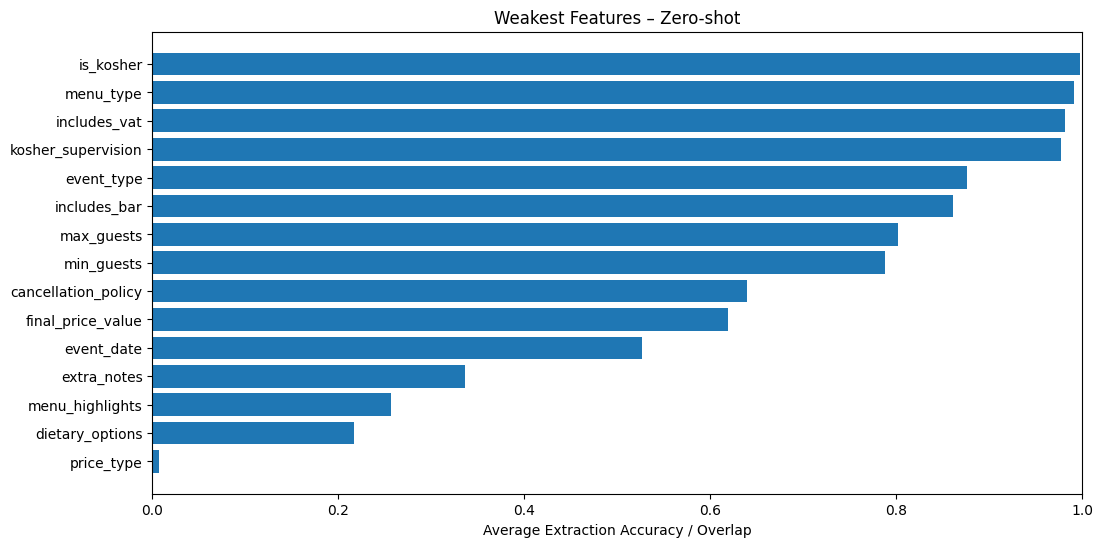


=== Few-shot OVERALL PERFORMANCE ===
Average exact match rate: 0.6558

=== Few-shot FEATURE-LEVEL PERFORMANCE ===
event_type                → 0.737
price_type                → 0.011
final_price_value         → 0.289
min_guests                → 0.953
max_guests                → 0.966
includes_vat              → 0.967
is_kosher                 → 0.998
kosher_supervision        → 0.978
includes_bar              → 0.841
menu_type                 → 0.985
dietary_options           → 0.257
event_date                → 0.513
cancellation_policy       → 0.651
menu_highlights           → 0.350
extra_notes               → 0.341


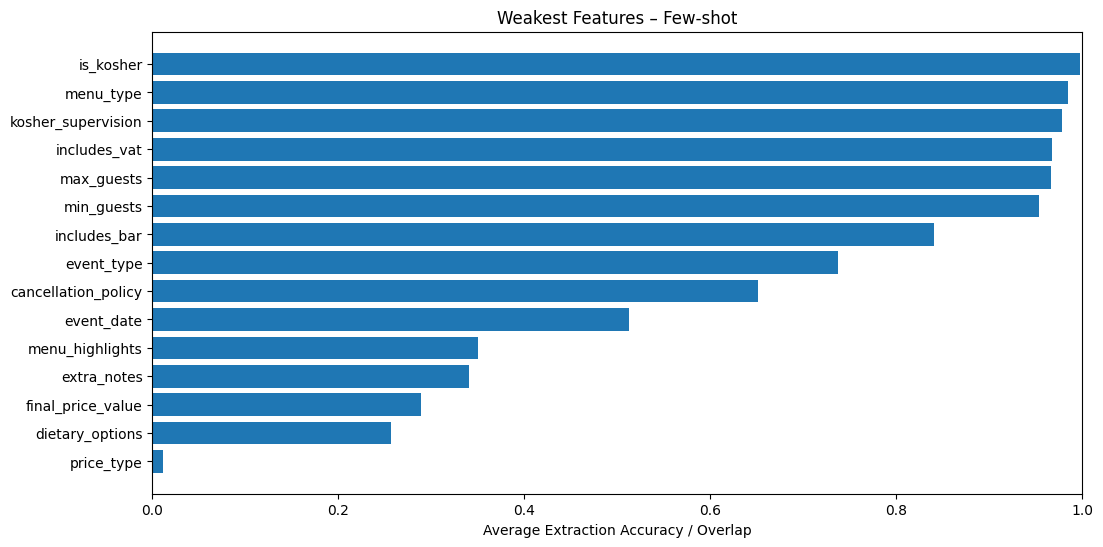

In [18]:
PRED_DIR_ZERO = "data/Cater Mails/extracted features zero-shot"
PRED_DIR_FEW  = "data/Cater Mails/extracted features few-shot"

zero_avg, zero_features = run_eda(PRED_DIR_ZERO, label="Zero-shot")
few_avg,  few_features  = run_eda(PRED_DIR_FEW,  label="Few-shot")


In [13]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizerFast
from collections import defaultdict

# ---- DEVICE ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 512
BATCH_SIZE = 1
LR = 2e-5
EPOCHS = 10

# ---- MAPS ----
EVENT_TYPE_MAP = {"wedding":0, "gala":1, "corporate":2, "other":3}
PRICE_TYPE_MAP = {"per_person":0, "fixed":1, "range":2, "unknown":3}
KOSHER_MAP = {"none":0,"rabbi":1,"certified":2}  # example
MENU_TYPE_MAP = {"buffet":0,"plated":1,"family":2,"cocktail":3,"other":4}
POLICY_MAP = {"strict":0,"moderate":1,"flexible":2,"none":3}

NUM_DIETARY = 10       # number of possible dietary options
NUM_HIGHLIGHTS = 10    # number of possible menu highlights
NUM_NOTES = 10         # number of extra notes types

# ---- NORMALIZATION ----
def normalize_event_type(text):
    if text is None: return "other"
    t = str(text).lower()
    if "wedding" in t: return "wedding"
    if "gala" in t: return "gala"
    if "corporate" in t or "retreat" in t: return "corporate"
    return "other"

def normalize_price_type(text):
    if text is None: return "unknown"
    t = str(text).lower()
    if "per" in t: return "per_person"
    if "fixed" in t: return "fixed"
    if "range" in t: return "range"
    return "unknown"

def map_includes_bar(value):
    if value is None:
        return 0.0
    if isinstance(value, str):
        if value.lower() in ["no", "none"]:
            return 0.0
        else:
            return 1.0  # anything else counts as "yes/cash bar/etc"
    return float(value)

# ---- MULTI-HOT ENCODING ----
def multi_hot(values, size):
    vec = torch.zeros(size)
    if not values:
        return vec
    for v in values:
        if isinstance(v,int) and v < size:
            vec[v] = 1
    return vec

# ---- CONVERT DATE TO NUMBER ----
def date_to_number(date_str):
    if not date_str:
        return 0.0
    try:
        # example: YYYY-MM-DD → float YYYYMMDD
        parts = [int(x) for x in date_str.split("-")]
        return float(parts[0]*10000 + parts[1]*100 + parts[2])
    except:
        return 0.0

# ---- DATASET ----
class EmailContractDataset(Dataset):
    def __init__(self, email_dir, gt_dir, tokenizer):
        self.email_dir = email_dir
        self.gt_dir = gt_dir
        self.tokenizer = tokenizer
        self.files = sorted([f for f in os.listdir(email_dir) if f.endswith(".txt")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        email_file = self.files[idx]
        base_id = email_file.split("_")[-1].replace(".txt","")

        with open(os.path.join(self.email_dir, email_file), encoding="utf-8") as f:
            email_text = f.read()

        with open(os.path.join(self.gt_dir, f"ground_truth_{base_id}.json"), encoding="utf-8") as f:
            gt = json.load(f)

        encoding = self.tokenizer(
            email_text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        # ---- SCALE NUMERIC FIELDS ----
        final_price = float(gt.get("final_price_value") or 0.0)/1000.0
        min_guests = float(gt.get("min_guests") or 0.0)/100.0
        max_guests = float(gt.get("max_guests") or 0.0)/100.0
        event_date = date_to_number(gt.get("event_date")) / 100000000.0

        dietary = gt.get("dietary_options", [])
        menu_highlights = gt.get("menu_highlights", [])
        extra_notes = gt.get("extra_notes", [])

        labels = {
            # classification
            "event_type": torch.tensor(EVENT_TYPE_MAP.get(normalize_event_type(gt.get("event_type")),3), dtype=torch.long),
            "price_type": torch.tensor(PRICE_TYPE_MAP.get(normalize_price_type(gt.get("price_type")),3), dtype=torch.long),
            "kosher_supervision": torch.tensor(KOSHER_MAP.get(gt.get("kosher_supervision"),2), dtype=torch.long),
            "menu_type": torch.tensor(MENU_TYPE_MAP.get(gt.get("menu_type"),4), dtype=torch.long),
            "cancellation_policy": torch.tensor(POLICY_MAP.get(gt.get("cancellation_policy"),3), dtype=torch.long),

            # binary
            "includes_vat": torch.tensor([float(gt.get("includes_vat") or 0.0)], dtype=torch.float),
            "is_kosher": torch.tensor([float(gt.get("is_kosher") or 0.0)], dtype=torch.float),
            "includes_bar": torch.tensor([map_includes_bar(gt.get("includes_bar"))], dtype=torch.float),

            # regression
            "final_price_value": torch.tensor([final_price], dtype=torch.float),
            "min_guests": torch.tensor([min_guests], dtype=torch.float),
            "max_guests": torch.tensor([max_guests], dtype=torch.float),
            "event_date": torch.tensor([event_date], dtype=torch.float),

            # multi-label
            "dietary_options": multi_hot(dietary, NUM_DIETARY),
            "menu_highlights": multi_hot(menu_highlights, NUM_HIGHLIGHTS),
            "extra_notes": multi_hot(extra_notes, NUM_NOTES)
        }

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": labels
        }

# ---- TOKENIZER ----
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
dataset = EmailContractDataset(
    email_dir="data/Cater Mails/email threads",
    gt_dir="data/Cater Mails/ground truth",
    tokenizer=tokenizer
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ---- MODEL ----
class ContractExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        hidden = self.encoder.config.hidden_size

        # classification
        self.event_type = nn.Linear(hidden, 4)
        self.price_type = nn.Linear(hidden, 4)
        self.kosher_supervision = nn.Linear(hidden, 3)
        self.menu_type = nn.Linear(hidden, 5)
        self.cancellation_policy = nn.Linear(hidden, 4)

        # binary
        self.includes_vat = nn.Linear(hidden,1)
        self.is_kosher = nn.Linear(hidden,1)
        self.includes_bar = nn.Linear(hidden,1)

        # regression
        self.final_price_value = nn.Linear(hidden,1)
        self.min_guests = nn.Linear(hidden,1)
        self.max_guests = nn.Linear(hidden,1)
        self.event_date = nn.Linear(hidden,1)

        # multi-label
        self.dietary_options = nn.Linear(hidden, NUM_DIETARY)
        self.menu_highlights = nn.Linear(hidden, NUM_HIGHLIGHTS)
        self.extra_notes = nn.Linear(hidden, NUM_NOTES)

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = out.last_hidden_state  # [B, T, H]
        mask = attention_mask.unsqueeze(-1).float()  # [B, T, 1]

        pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

        return {
            "event_type": self.event_type(pooled),
            "price_type": self.price_type(pooled),
            "kosher_supervision": self.kosher_supervision(pooled),
            "menu_type": self.menu_type(pooled),
            "cancellation_policy": self.cancellation_policy(pooled),

            "includes_vat": self.includes_vat(pooled),
            "is_kosher": self.is_kosher(pooled),
            "includes_bar": self.includes_bar(pooled),

            "final_price_value": self.final_price_value(pooled),
            "min_guests": self.min_guests(pooled),
            "max_guests": self.max_guests(pooled),
            "event_date": self.event_date(pooled),

            "dietary_options": self.dietary_options(pooled),
            "menu_highlights": self.menu_highlights(pooled),
            "extra_notes": self.extra_notes(pooled),
        }


model = ContractExtractor().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# ---- LOSSES ----
loss_cls = nn.CrossEntropyLoss()
loss_bin = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()
loss_multi = nn.BCEWithLogitsLoss(
    pos_weight=torch.ones(NUM_DIETARY).to(DEVICE) * 3.0
)

loss_weights = {
    "price_type": 3.0,
    "final_price_value": 2.0,
    "dietary_options": 2.0,
    "menu_highlights": 2.0,
    "extra_notes": 1.5,
}


# ---- TRAINING LOOP ----
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = {k:v.to(DEVICE) for k,v in batch["labels"].items()}

        outputs = model(input_ids, attention_mask)

        loss = (
            loss_cls(outputs["event_type"], labels["event_type"].view(-1)) +

            loss_weights["price_type"] *
            loss_cls(outputs["price_type"], labels["price_type"].view(-1)) +

            loss_cls(outputs["kosher_supervision"], labels["kosher_supervision"].view(-1)) +
            loss_cls(outputs["menu_type"], labels["menu_type"].view(-1)) +
            loss_cls(outputs["cancellation_policy"], labels["cancellation_policy"].view(-1)) +

            loss_bin(outputs["includes_vat"], labels["includes_vat"]) +
            loss_bin(outputs["is_kosher"], labels["is_kosher"]) +
            loss_bin(outputs["includes_bar"], labels["includes_bar"]) +

            loss_weights["final_price_value"] *
            loss_reg(outputs["final_price_value"], labels["final_price_value"]) +

            loss_reg(outputs["min_guests"], labels["min_guests"]) +
            loss_reg(outputs["max_guests"], labels["max_guests"]) +
            loss_reg(outputs["event_date"], labels["event_date"]) +

            loss_weights["dietary_options"] *
            loss_multi(outputs["dietary_options"], labels["dietary_options"]) +

            loss_weights["menu_highlights"] *
            loss_multi(outputs["menu_highlights"], labels["menu_highlights"]) +

            loss_weights["extra_notes"] *
            loss_multi(outputs["extra_notes"], labels["extra_notes"])
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} finished | Avg loss: {total_loss/len(loader):.4f}")

Epoch 1 finished | Avg loss: 32.4115
Epoch 2 finished | Avg loss: 29.4067
Epoch 3 finished | Avg loss: 26.3856
Epoch 4 finished | Avg loss: 23.9195
Epoch 5 finished | Avg loss: 22.2535
Epoch 6 finished | Avg loss: 18.8540
Epoch 7 finished | Avg loss: 16.9394
Epoch 8 finished | Avg loss: 15.5020
Epoch 9 finished | Avg loss: 13.9386
Epoch 10 finished | Avg loss: 11.9433


In [14]:
from collections import defaultdict
import torch

def evaluate_model_average(model, loader, tolerance=0.1):
    model.eval()
    per_field_scores = defaultdict(list)

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            gt = batch["labels"]
            out = model(input_ids, attention_mask)

            # ---------- predictions ----------
            pred = {
                "event_type": torch.argmax(out["event_type"], -1),
                "price_type": torch.argmax(out["price_type"], -1),
                "kosher_supervision": torch.argmax(out["kosher_supervision"], -1),
                "menu_type": torch.argmax(out["menu_type"], -1),
                "cancellation_policy": torch.argmax(out["cancellation_policy"], -1),

                "includes_vat": (torch.sigmoid(out["includes_vat"]) > 0.5).long(),
                "is_kosher": (torch.sigmoid(out["is_kosher"]) > 0.5).long(),
                "includes_bar": (torch.sigmoid(out["includes_bar"]) > 0.5).long(),

                "final_price_value": out["final_price_value"],
                "min_guests": out["min_guests"],
                "max_guests": out["max_guests"],
                "event_date": out["event_date"],

                "dietary_options": (torch.sigmoid(out["dietary_options"]) > 0.5).long(),
                "menu_highlights": (torch.sigmoid(out["menu_highlights"]) > 0.5).long(),
                "extra_notes": (torch.sigmoid(out["extra_notes"]) > 0.5).long(),
            }

            for k in pred.keys():
                p = pred[k]
                g = gt[k].to(p.device)

                # ---------- regression ----------
                if k in ["final_price_value","min_guests","max_guests","event_date"]:
                    rel_err = torch.abs(p - g) / (torch.abs(g) + 1e-6)
                    score = (rel_err < tolerance).float().mean().item()
                    per_field_scores[k].append(score)

                # ---------- multi-label ----------
                elif k in ["dietary_options","menu_highlights","extra_notes"]:
                    p = p[0]
                    g = g[0]
                    if g.sum() == 0 and p.sum() == 0:
                        per_field_scores[k].append(1.0)
                    else:
                        tp = ((p == 1) & (g == 1)).sum().item()
                        fp = ((p == 1) & (g == 0)).sum().item()
                        fn = ((p == 0) & (g == 1)).sum().item()
                        f1 = 0.0 if tp == 0 else (2 * tp) / (2 * tp + fp + fn)
                        per_field_scores[k].append(f1)

                # ---------- categorical / binary ----------
                else:
                    acc = (p.view(-1) == g.view(-1)).float().mean().item()
                    per_field_scores[k].append(float(acc))

    field_avg = {k: sum(v)/len(v) for k,v in per_field_scores.items()}
    overall = sum(field_avg.values()) / len(field_avg)

    print(f"\nAverage Score (all fields): {overall:.4f}")
    print("Per-field Scores:")
    for k,v in field_avg.items():
        print(f"  {k:25s}: {v:.3f}")

    return overall, field_avg


In [15]:
avg_match, field_acc = evaluate_model_average(model, loader)



Average Score (all fields): 0.7414
Per-field Scores:
  event_type               : 0.579
  price_type               : 0.944
  kosher_supervision       : 1.000
  menu_type                : 1.000
  cancellation_policy      : 0.996
  includes_vat             : 0.851
  is_kosher                : 0.998
  includes_bar             : 0.600
  final_price_value        : 0.250
  min_guests               : 0.173
  max_guests               : 0.521
  event_date               : 0.209
  dietary_options          : 1.000
  menu_highlights          : 1.000
  extra_notes              : 1.000


In [43]:
import os
import re
import json
from gliner import GLiNER

# Make sure paths exist
os.makedirs("data/Cater Mails/email threads", exist_ok=True)
os.makedirs("data/Cater Mails/ground_truth", exist_ok=True)
os.makedirs("data/Cater Mails/extracted_features", exist_ok=True)


In [51]:
LABELS = {
    "event_type": "Words like wedding, gala, conference, party",
    "price_type": "Look for phrases: per person, fixed price, range",
    "final_price_value": "Numbers with $ or currency symbols",
    "min_guests": "Phrases like minimum 50 guests",
    "max_guests": "Phrases like maximum 200 guests",
    "includes_vat": "Contains VAT included or excluded",
    "is_kosher": "Mentions kosher food",
    "kosher_supervision": "Mentions Orthodox Union or other supervision",
    "includes_bar": "Mentions bar, beverages included or excluded",
    "menu_type": "Look for meat, dairy, mixed, pareve",
    "dietary_options": "Vegetarian, vegan, gluten-free etc.",
    "event_date": "Dates in any format",
    "cancellation_policy": "Words like cancellation, refund",
    "menu_highlights": "Specific dishes mentioned",
    "extra_notes": "Anything extra mentioned"
}


In [52]:
def extract_first_last_email(thread_text: str):
    # Split by email markers
    emails = re.split(r"Email \d+ – (?:Food Supplier|Event Organizer):", thread_text)
    emails = [e.strip() for e in emails if e.strip()]
    if not emails:
        return "", ""
    return emails[0], emails[-1]


In [53]:
# Load GLiNER model
model = GLiNER.from_pretrained("urchade/gliner_medium")

def predict_features(thread_text):
    first_email, last_email = extract_first_last_email(thread_text)
    text = first_email + "\n" + last_email

    raw_entities = model.predict_entities(text, LABELS)

    # Deduplicate by (label, text)
    seen = {}
    for e in raw_entities:
        key = (e["label"], e["text"].lower())
        seen[key] = e
    raw_entities = list(seen.values())

    # Map entities to required JSON
    features = {
        "event_type": None,
        "price_type": None,
        "final_price_value": None,
        "min_guests": None,
        "max_guests": None,
        "includes_vat": None,
        "is_kosher": None,
        "kosher_supervision": None,
        "includes_bar": None,
        "menu_type": None,
        "dietary_options": [],
        "event_date": None,
        "cancellation_policy": None,
        "menu_highlights": [],
        "extra_notes": None
    }

    for e in raw_entities:
        label = e["label"].upper()
        text_val = e["text"].strip()
        if label in ["DIETARY_OPTIONS", "MENU_HIGHLIGHTS"]:
            features[label.lower()] = list(set(features[label.lower()]) | {text_val})
        elif label in features:
            features[label.lower()] = text_val

    return features


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
from sklearn.metrics import f1_score

LIST_FIELDS = {"dietary_options", "menu_highlights"}
CATEGORICAL_FIELDS = {"price_type", "menu_type"}

def normalize(value):
    if value is None:
        return None
    if isinstance(value, str):
        return value.strip().lower()
    if isinstance(value, list):
        return [str(x).strip().lower() for x in value]
    return value

def convert_to_list(value):
    if value is None:
        return []
    if isinstance(value, list):
        return normalize(value)
    return [normalize(value)]

def list_overlap_score(pred_list, gold_list):
    pred_set = set(pred_list)
    gold_set = set(gold_list)
    if not gold_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & gold_set) / len(gold_set)

def evaluate(pred, gold):
    exact_matches = []
    for key in gold:
        g = gold.get(key)
        p = pred.get(key)
        if key in LIST_FIELDS:
            score = list_overlap_score(convert_to_list(p), convert_to_list(g))
            exact_matches.append(score)
        else:
            exact_matches.append(normalize(p) == normalize(g))
    exact_match_rate = sum([1 if x is True else x for x in exact_matches]) / len(exact_matches)

    # F1 for categorical fields
    y_true, y_pred = [], []
    for key in CATEGORICAL_FIELDS:
        g_val = normalize(gold.get(key))
        p_val = normalize(pred.get(key))
        if g_val is not None and p_val is not None:
            y_true.append(g_val)
            y_pred.append(p_val)
    categorical_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0) if y_true else None

    return {"exact_match_rate": exact_match_rate, "categorical_f1": categorical_f1}


In [60]:
num_threads = 30
all_results = []

for i in range(1, num_threads + 1):
    email_file = f"data/Cater Mails/email threads/email_thread_{i:03d}.txt"
    gold_file = f"data/Cater Mails/ground truth/ground_truth_{i:03d}.json"
    pred_file = f"data/Cater Mails/extracted_features/predicted_{i:03d}.json"

    with open(email_file, "r", encoding="utf-8") as f:
        thread_text = f.read()
    with open(gold_file, "r", encoding="utf-8") as f:
        ground_truth = json.load(f)

    predicted = predict_features(thread_text)

    # Save prediction
    with open(pred_file, "w", encoding="utf-8") as f:
        json.dump(predicted, f, indent=2)

    result = evaluate(predicted, ground_truth)
    all_results.append(result)

# Average across threads
avg_exact = sum(r["exact_match_rate"] for r in all_results) / len(all_results)
print("Average exact match rate:", avg_exact)


Average exact match rate: 0.05999999999999999


**Observation:** The overall scores are very low.  

The main reason is that the GLiNER model output often does not align with the required JSON format.  
This mismatch during post-processing leads to missing or incorrectly mapped fields, which drastically reduces the exact match and categorical F1 scores.